In [1]:
# -------- Imports --------
import sys
import os
import numpy as np
from scipy.integrate import solve_ivp
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from _utility import *


In [2]:
# -------- Parameters --------
# -- Grid parameters --
Nx, Ny  = 200, 200
dx, dy = 1.0, 1.0
psi_len = Nx*Ny + (Nx-1)*Ny + Nx*(Ny-1) # Number of values for the staggered grid

# -- Simulation parameters --
Nt = 100
dt = 3.0


### Source Pre-Calculation

In [3]:
# -------- Source Regions --------
# -- Source region parameters (Example: Homogeneous) --
# Velocity (c)
c0_S = 3

# Density (rho)
rho0_S = 2

# -- Point source function --
t_span = (0, 10.0)          # Source activation time span
f0 = 0.2                    # Central frequency of the Ricker wavelet
A = 10.0                     # Amplitude of the source
S0 = lambda t: Ricker(f0, t, 0, 0, x0=5) * A

# -- Grid parameters --
r_x = int((1/dx)*t_span[1] * c0_S)  # Radius of the source region (x)
r_y = int((1/dy)*t_span[1] * c0_S)  # Radius of the source region (y)
Nx_S, Ny_S = (2*r_x, 2*r_y)         # Number of grid points in the source region

# -- Wave field definition --
u0_S = np.zeros((Ny_S, Nx_S))
v0x_S = np.zeros((Ny_S, (Nx_S-1)))
v0y_S = np.zeros(((Ny_S-1), Nx_S))
phi_0_S = np.hstack([u0_S.flatten(), v0x_S.flatten(), v0y_S.flatten()])

# -- Material properties --
c_model_S = c0_S * np.ones((Ny_S, Nx_S))
rho_model_S = rho0_S * np.ones((Ny_S, Nx_S))
rho_stag_x_S = rho0_S * np.ones((Ny_S, (Nx_S-1)))
rho_stag_y_S = rho0_S * np.ones(((Ny_S-1), Nx_S))

# -------- Simulation (2D Acoustic) --------
(H_S, A_S, B_S, _, B_inv_S, _) = FD_solver_2D(Nx_S, Ny_S, dx, dy, c_model_S, rho_model_S, rho_stag_x_S, rho_stag_y_S)

# -------- Classical source simulation --------
# Integration definition
def rhs(t, phi):
    wave = B_inv_S @ A_S @ phi
    source = np.zeros_like(phi)
    source[Nx_S//2*Ny_S + Nx_S//2] = S0(t) # Inject source at the center of the source region
    return wave + source

# Time Integration
source_initial = solve_ivp(rhs, t_span, phi_0_S, t_eval=t_span, method='DOP853').y.T[-1]
S_u = source_initial[:Ny_S*Nx_S].reshape((Ny_S, Nx_S))
S_vx = source_initial[Ny_S*Nx_S:Ny_S*Nx_S + Ny_S*(Nx_S-1)].reshape((Ny_S, Nx_S-1))
S_vy = source_initial[Ny_S*Nx_S + Ny_S*(Nx_S-1):].reshape((Ny_S-1, Nx_S))


In [4]:
# -- Wave field definition --
# All sources act at the same time
Sx0_A, Sy0_A = 30, 30       # Define the center of source A in the global model
Sx0_B, Sy0_B = 170, 170     # Define the center of source B in the global model
Sx0_C, Sy0_C = 60, 120      # Define the center of source C in the global model

# Pressure field (u)
u0 = np.zeros((Ny, Nx))
u0[Sx0_A-r_x:Sx0_A+r_x, Sy0_A-r_y:Sy0_A+r_y] = S_u
u0[Sx0_B-r_x:Sx0_B+r_x, Sy0_B-r_y:Sy0_B+r_y] = S_u
u0[Sx0_C-r_x:Sx0_C+r_x, Sy0_C-r_y:Sy0_C+r_y] = S_u

# Particle velocity field x (vx)
v0x = np.zeros((Ny, (Nx-1)))
v0x[Sx0_A-r_x:Sx0_A+r_x, Sy0_A-r_y:Sy0_A+r_y-1] = S_vx
v0x[Sx0_B-r_x:Sx0_B+r_x, Sy0_B-r_y:Sy0_B+r_y-1] = S_vx
v0x[Sx0_C-r_x:Sx0_C+r_x, Sy0_C-r_y:Sy0_C+r_y-1] = S_vx

# Particle velocity field y (vy)
v0y = np.zeros(((Ny-1), Nx))
v0y[Sx0_A-r_x:Sx0_A+r_x-1, Sy0_A-r_y:Sy0_A+r_y] = S_vy
v0y[Sx0_B-r_x:Sx0_B+r_x-1, Sy0_B-r_y:Sy0_B+r_y] = S_vy
v0y[Sx0_C-r_x:Sx0_C+r_x-1, Sy0_C-r_y:Sy0_C+r_y] = S_vy

# -- Material properties --
# Velocity (c)
c0 = 3
c_model = c0 * np.ones((Ny, Nx))

# Density (rho)
rho0 = 2
rho_model = rho0 * np.ones((Ny, Nx))
rho_stag_x = rho0 * np.ones((Ny, (Nx-1)))
rho_stag_y = rho0 * np.ones(((Ny-1), Nx))

# -------- Simulation (2D Acoustic) --------
(H, _, _, B_sqrt, _, B_inv_sqrt) = FD_solver_2D(Nx, Ny, dx, dy, c_model, rho_model, rho_stag_x, rho_stag_y)


In [5]:
# -------- Initial State  --------
# Stack the initial conditions
phi_0 = np.hstack([u0.flatten(), v0x.flatten(), v0y.flatten()])

# Normalize the initial state and transform it to the energy basis
psi_0 = B_sqrt @ phi_0
norm = np.linalg.norm(psi_0)
psi_0 /= norm


In [6]:
# -------- Time Evolution --------
# Evolve the state over time (energy basis)
psi_t = sp.linalg.expm_multiply(-1j * H, psi_0, start=0, stop=Nt*dt, num=Nt, endpoint=True).real


In [7]:
# -------- Final State --------
# Transform the state back to the original basis
phi_t = norm * (B_inv_sqrt @ psi_t.T).T


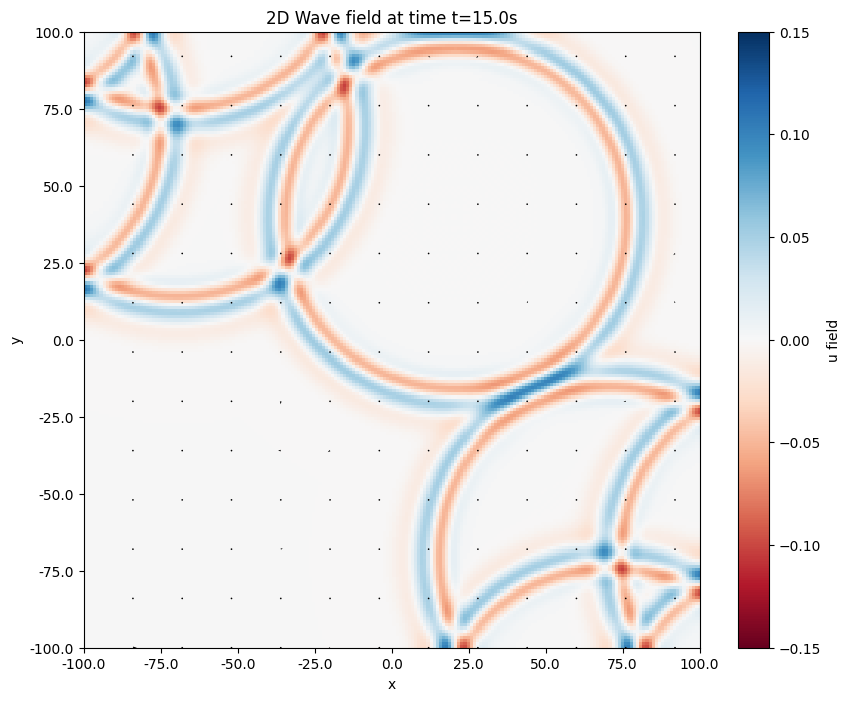

In [8]:
# -------- Plot --------
t_plot = 5
plot_acoustic_2D(phi_t[t_plot], Nx, Ny, dx, dy, title=f'2D Wave field at time t={t_plot*dt}s')
